In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import tensorflow
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import models, layers

import numpy as np
import os 
import glob
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split


In [2]:
train_dir=r"../input/face-mask-12k-images-dataset/Face Mask Dataset/Train"
test_dir=r"../input/face-mask-12k-images-dataset/Face Mask Dataset/Test"
val_dir=r"../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation"

mask_train_dir=r"../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask"
no_mask_train_dir=r"../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithoutMask"
mask_valid_dir=r"../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithMask"
no_mask_valid_dir=r"../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask"
mask_test_dir=r"../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask"
no_mask_test_dir=r"../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask"
dirlist=[mask_train_dir, no_mask_train_dir, mask_valid_dir, no_mask_valid_dir, mask_test_dir, no_mask_test_dir]
classes=['mask', 'no_mask', 'mask', 'no_mask', 'mask', 'no_mask']
filepaths=[]
labels=[]
for d,c in zip(dirlist, classes): #loop inside the directories (folders) 
    flist=os.listdir(d) #file
    for f in flist:
        fpath=os.path.join (d,f) 
        filepaths.append(fpath) #add file paths - pictures
        labels.append(c)  #add labels - no mask / mask on
print ('filepaths: ', len(filepaths), '   labels: ', len(labels)) 

filepaths:  11792    labels:  11792


In [3]:
Fseries=pd.Series(filepaths, name='file_paths') #create a series to contains pics and labels 
Lseries=pd.Series(labels, name='labels') 
df=pd.concat([Fseries,Lseries], axis=1)   #Concatenate the two series 
df=pd.DataFrame(np.array(df).reshape(11792,2), columns = ['file_paths', 'labels'])#reshape 11792 row ,2 cols
print(df['labels'].value_counts()) #show the number of the labels in the df 

no_mask    5909
mask       5883
Name: labels, dtype: int64


In [4]:
train_df, test_df=train_test_split(df, train_size=0.95, shuffle=True)
train_df, valid_df=train_test_split(train_df, train_size=0.9, shuffle=True)

## Image Examples

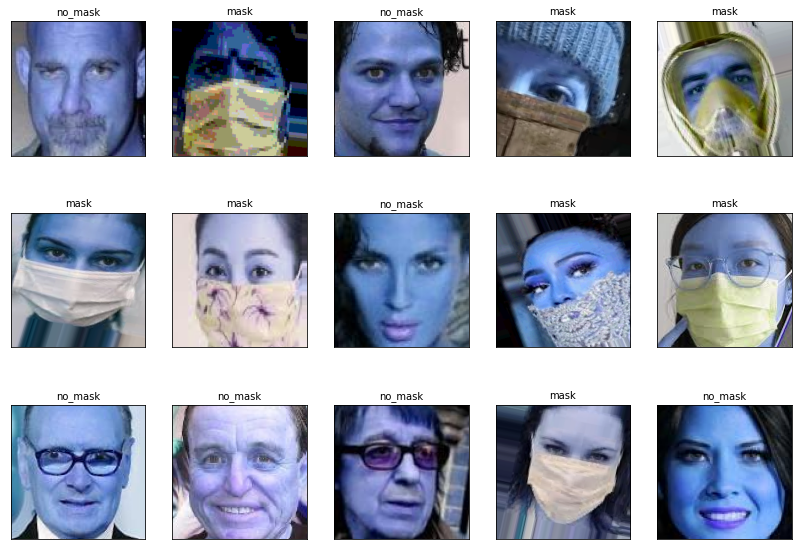

In [5]:
plt.figure(figsize=(14,10))
for i in range(15): #show only 15 images randomly from the df 
    random = np.random.randint(1,len(df)) 
    plt.subplot(3,5,i+1) #plot 3 rows 5 cols
    plt.imshow(cv2.imread(df.loc[random,"file_paths"])) #read the images from this dataframe--> filepath
    plt.title(df.loc[random, "labels"], size = 10, color = "black") #show labels with the images
    plt.xticks([]) #to removethe current tick locations and labels of the x-axis.
    plt.yticks([])#to removethe current tick locations and labels of the y-axis.
    
plt.show()

### DATA PROCESSING / IMAGE PROCESSING

In [6]:

target_size=(96,96) #size of all images 96 x 96 pixels
batch_size = 16 

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size, 
    batch_size=batch_size,
    color_mode='rgb',    
    shuffle=True, 
    seed=42,
    class_mode='categorical') #problem type

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False,    
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb', 
    shuffle=False,    
    class_mode='categorical')

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


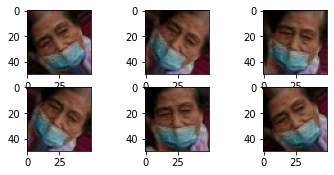

In [7]:
from numpy import expand_dims
#rotation_range
img1 = load_img('../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask/1004.png')
data = img_to_array(img1)
samples = expand_dims(data, 0)
datagen = ImageDataGenerator(rotation_range=40)
it = datagen.flow(samples, batch_size=1)
for i in range(6):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

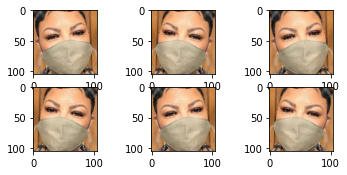

In [8]:
#horizontal_flip
img = load_img('../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask/102.png')
data = img_to_array(img)
samples = expand_dims(data, 0)
datagen = ImageDataGenerator(horizontal_flip=True)
it = datagen.flow(samples, batch_size=1)
for i in range(6):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)


In [9]:
train_df, test_df=train_test_split(df, train_size=0.95, shuffle=True)
train_df, valid_df=train_test_split(train_df, train_size=0.9, shuffle=True)

In [10]:
print(train_df.labels.value_counts())
print(valid_df.labels.value_counts())
print(test_df.labels.value_counts())

no_mask    5075
mask       5006
Name: labels, dtype: int64
mask       586
no_mask    535
Name: labels, dtype: int64
no_mask    299
mask       291
Name: labels, dtype: int64


## Bulied the Model

In [11]:
num_classes = 2 # WithMask, WithoutMask
input_shape = (96,96,3)
# Build Model
model = models.Sequential()
# 1st Conv layer
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024))
model.add(layers.Dense(64))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

2022-05-19 17:48:59.843354: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 96)        5

In [12]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input, zoom_range=0.2, rotation_range=40)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
train_gen = train_datagen.flow_from_dataframe(train_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')
valid_gen = test_datagen.flow_from_dataframe(valid_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')

Found 10081 validated image filenames belonging to 2 classes.
Found 1121 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [13]:
# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='Adam',  metrics=['accuracy'])

In [14]:
#train - setting values 

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST =test_generator.n//test_generator.batch_size
num_epochs = 20

In [15]:
model.fit_generator(train_generator,steps_per_epoch=STEP_SIZE_TRAIN,epochs=num_epochs,
                    validation_data=valid_generator, 
                    validation_steps=STEP_SIZE_VALID) #, callbacks=[checkpoint])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-05-19 17:49:07.211225: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
625/625 [==============================] - 112s 177ms/step - loss: 0.3102 - accuracy: 0.8735 - val_loss: 0.2090 - val_accuracy: 0.9287
Epoch 2/20
625/625 [==============================] - 67s 108ms/step - loss: 0.2603 - accuracy: 0.9012 - val_loss: 0.2137 - val_accuracy: 0.9250
Epoch 3/20
625/625 [==============================] - 69s 110ms/step - loss: 0.2399 - accuracy: 0.9105 - val_loss: 0.1580 - val_accuracy: 0.9575
Epoch 4/20
625/625 [==============================] - 72s 114ms/step - loss: 0.2150 - accuracy: 0.9186 - val_loss: 0.1702 - val_accuracy: 0.9300
Epoch 5/20
625/625 [==============================] - 68s 108ms/step - loss: 0.2010 - accuracy: 0.9259 - val_loss: 0.1827 - val_accuracy: 0.9350
Epoch 6/20
625/625 [==============================] - 68s 109ms/step - loss: 0.2001 - accuracy: 0.9262 - val_loss: 0.1648 - val_accuracy: 0.9488
Epoch 7/20
625/625 [==============================] - 68s 109ms/step - loss: 0.1831 - accuracy: 0.9319 - val_loss: 0.1205 - val_a

In [16]:
models.save_model(model, "Face-mask-detection-f.h5") # save the model

In [17]:
score = model.evaluate(test_generator, steps=STEP_SIZE_TEST)
print(score)

62/62 [==============================] - 8s 134ms/step - loss: 0.0765 - accuracy: 0.9758
[0.07652608305215836, 0.975806474685669]


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
pred_y=model.predict(test_generator)
pred = np.argmax(pred_y,axis=1)

y_actual = test_generator.classes
cm = confusion_matrix(y_actual, pred)
print(cm)

[[461  22]
 [  2 507]]


# Prediction

In [19]:
%matplotlib inline
import tensorflow
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def predict_img(img_path):
    img1 = image.load_img(img_path, target_size=(100, 100))
    img = image.img_to_array(img1)
    img = img/255


    # create a batch of size 1 [N,H,W,C]

    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img, batch_size=None,steps=1) #gives all class prob.

    if(prediction[0][0]>0.5):
        value ='with-mask'

        plt.text(20, 62,value,color='green',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
    else:
        value ='without-mask'
        plt.text(20,62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
    plt.imshow(img1) 

    plt.show()

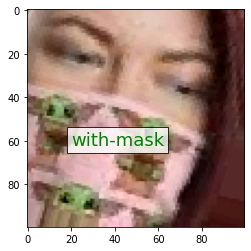

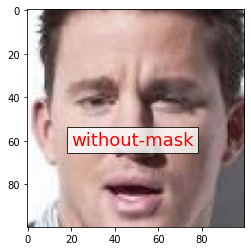

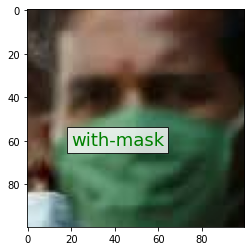

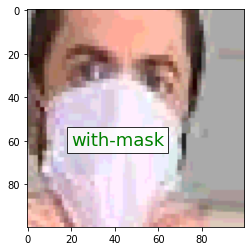

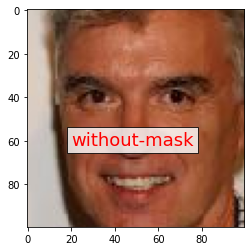

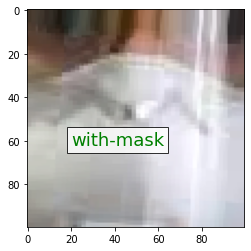

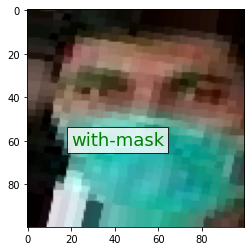

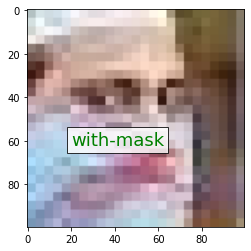

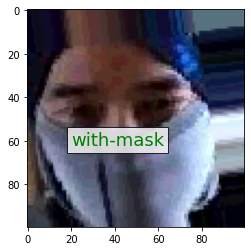

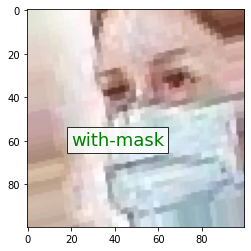

In [20]:
import random
for _ in range(0,10):
    path =  random.choice(test_generator.filepaths)
    predict_img(path)

In [21]:
labels = ['withMask', 'withoutMask']
print(classification_report(y_actual, pred, target_names=labels))

              precision    recall  f1-score   support

    withMask       1.00      0.95      0.97       483
 withoutMask       0.96      1.00      0.98       509

    accuracy                           0.98       992
   macro avg       0.98      0.98      0.98       992
weighted avg       0.98      0.98      0.98       992

